# Sparse arrays, dask, xarray, and the CESM land model component

By Deepak Cherian (CGD)

An underappreciated feature of Xarray + Dask is the ability to plug in different array types. Usually we work with Xarray wrapping a Dask array which in turn uses *NumPy* arrays for each block; or just Xarray wrapping NumPy arrays directly. NumPy arrays are dense in-memory arrays. Other array types exist:
- sparse for sparse arrays
- pint for units
- cupy for GPU arrays

Over the past few works, effort has been made to make these array types adhere to a common protocol so that higher-level packages like Xarray can easily wrap all of them.


This notebook explores using  sparse arrays with dask and xarray motivated by some Zulip conversations around representing "Plant Functional Types" from the land model component. A preliminary version of this notebook is at; and the work builds on `PFT-Gridding.ipynb`

## Importing Libraries

In [1]:
%matplotlib inline

import numpy as np
import sparse
import xarray as xr

## Constructing a sparse array

https://sparse.pydata.org/ provides a number of sparse array formats. Here we work with `sparse.COO`.

We construct a `sparse.COO` array by passing a list of non-zero data values and the coordinate locations for those values

In [8]:
# in this case shape=(3,3), dtype=np.int64, and fill_value=0 are set by default
eye = sparse.COO(coords=[[0, 1, 2], [0, 1, 2]], data=[1, 1, 1])
eye

Format,coo
Data Type,int64
Shape,"(3, 3)"
nnz,3
Density,0.3333333333333333
Read-only,True
Size,72
Storage ratio,1.0


To convert to a dense NumPy array use `.todense`

In [9]:
eye.todense()  # identity matrix!

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

A slightly more complicated example, with a bigger `shape`, and a custom `fill_value`

In [14]:
array = sparse.COO(
    coords=[[0, 1, 2], [0, 1, 2]],
    data=np.array([1, 1, 1], dtype=np.float32),
    shape=(4, 4),
    fill_value=np.nan,
)
array

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


In [15]:
array.todense()

array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)

## Wrapping sparse arrays in xarray

works seamlessly

In [19]:
da = xr.DataArray(array, coords={"x": np.arange(4), "y": np.arange(4)})
da

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


Access the underlying sparse array using `DataArray.data`

In [21]:
da.data

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


Convert to NumPy using `DataArray.as_numpy`

In [23]:
da.as_numpy()

<xarray.DataArray (x: 4, y: 4)>
array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3

Convert and extract the numpy array using `DataArray.to_numpy`

In [24]:
da.to_numpy()

array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)

Plotting works easily (the array is densified automatically before being passed to matplotlib)

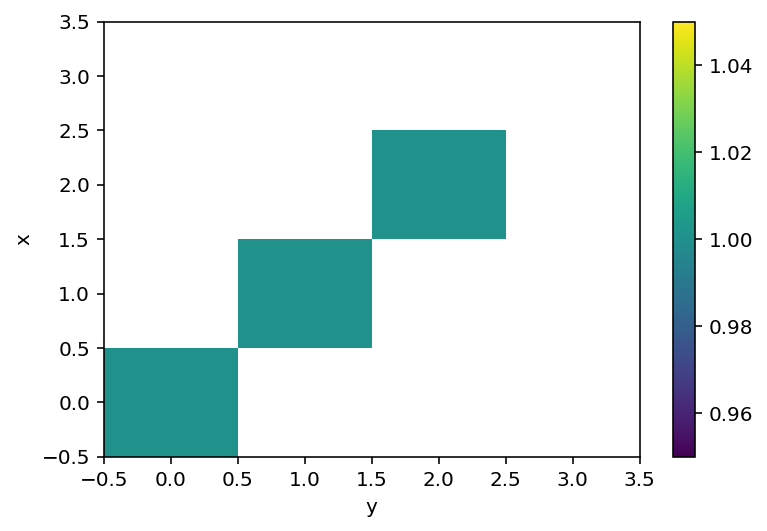

In [25]:
da.plot()

This works.

In [31]:
da.mean("x")

Format,coo
Data Type,float64
Shape,"(4,)"
nnz,3
Density,0.75
Read-only,True
Size,48
Storage ratio,1.5


## Sparse arrays with dask

also works seamlessly, dask recognizes that the chunks are sparse arrays (see Type under Chunk)

In [32]:
import dask.array

dasky_array = dask.array.from_array(array, chunks=2)
dasky_array

dask.array<array, shape=(4, 4), dtype=float32, chunksize=(2, 2), chunktype=sparse.COO>

## Sparse arrays with dask + xarray

works

In [34]:
xr.DataArray(dasky_array, coords={"x": [1, 2, 3, 4], "y": [1, 2, 3, 4]})

<xarray.DataArray 'array-4d2abbfe0c5bd4bdf5df7cf89e848638' (x: 4, y: 4)>
dask.array<array, shape=(4, 4), dtype=float32, chunksize=(2, 2), chunktype=sparse.COO>
Coordinates:
  * x        (x) int64 1 2 3 4
  * y        (y) int64 1 2 3 4

## Land model output

In [37]:
data = xr.open_dataset(
    "/glade/p/cgd/tss/people/dll/TRENDY2019_History/S0_control/TRENDY2019_S0_control_v2.clm2.h1.GPP.170001-201812.nc",
    decode_times=True,
    chunks={"time": 100},
)
data

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/p/cgd/tss/people/dll/TRENDY2019_History/S0_control/TRENDY2019_S0_control_v2.clm2.h1.GPP.170001-201812.nc'

### Convert the 1D PFT dataarrays to nD sparse arrays


In [35]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """ Takes an input numpy array and converts it to a sparse array."""
    import itertools

    import sparse

    codes = zip(vegtype, jxy - 1, ixy - 1)

    # some magic from https://github.com/pydata/xarray/pull/5577
    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        indexes = codes
    else:
        sizes = list(itertools.product(*[range(s) for s in data.shape[:-1]]))
        tuple_indexes = itertools.product(sizes, codes)
        indexes = map(lambda x: list(itertools.chain(*x)), tuple_indexes)

    return sparse.COO(
        coords=np.array(list(indexes)).T,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
    )


def convert_pft_variables_to_sparse(dataset):
    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = vegtype.max().load().item()
    # expected shape of sparse arrays (excludes time)
    output_sizes = {
        "pft": npft + 1,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["pft", "lat", "lon"]],
            exclude_dims=set(("pft",)),  # changes size
            dask="parallelized",
            kwargs=dict(shape=tuple(output_sizes.values())),
            dask_gufunc_kwargs=dict(
                meta=sparse.COO([]),
                output_sizes=output_sizes,
            ),  # lets dask know that we are changing from numpy to sparse
            output_dtypes=[pfts[var].dtype],
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["pft"] = np.arange(result.sizes["pft"])
    return result

In [36]:
pfts = convert_pft_variables_to_sparse(data1)
pfts

<xarray.Dataset>
Dimensions:             (lat: 192, lon: 288, pft: 78, time: 3828)
Coordinates:
  * lat                 (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time                (time) object 1700-01-16 11:44:59.999993 ... 2018-12-...
  * pft                 (pft) int64 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
Data variables: (12/15)
    pfts1d_lon          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_lat          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_ixy          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_jxy          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_gi           (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_li           (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    ...                  ...
    pfts1d_wtcol        (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_veg    (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_col    (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_lunit  (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_active       (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    GPP                 (time, pft, lat, lon) float64 dask.array<chunksize=(100, 78, 192, 288), meta=np.ndarray>

### test out a plot


xarray cannot handle directly plotting a sparse variable (yet). This  will be fixed soon; instead we manually "densify" to a numpy array using `.copy(data=gpp.data.todense())`

In [31]:
gpp = pfts.GPP.isel(time=3606).compute()
gpp = gpp.copy(data=gpp.data.todense())

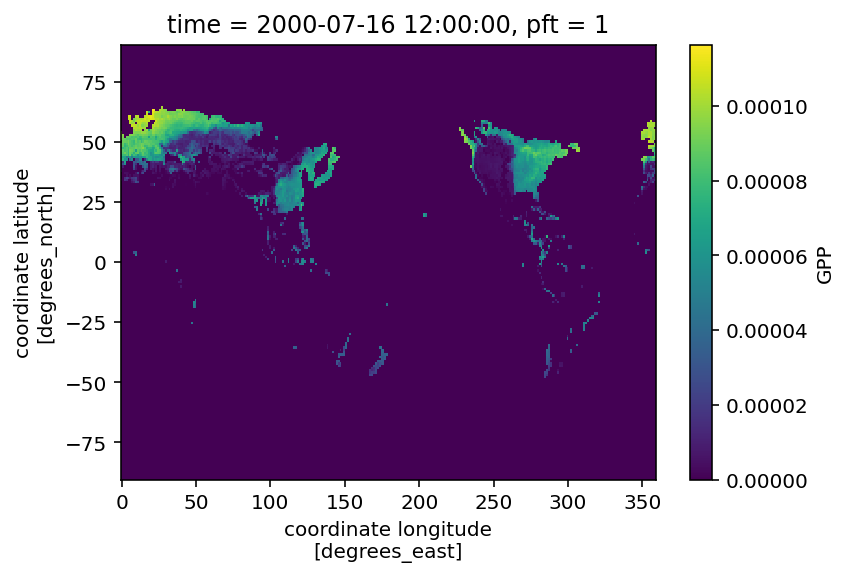

In [32]:
gpp.isel(pft=1).plot()